# Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autentikasi pengguna
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
file_id = '1GIuB_hYs37TOecpzSdmVPOMAHkmnmNUb'
downloaded_file = drive.CreateFile({'id': file_id})
downloaded_file.GetContentFile('/content/FLORA VISTA.zip')  # Simpan file di Colab sementara

In [5]:
import zipfile

with zipfile.ZipFile('/content/FLORA VISTA.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset_Floravista')  # Ekstrak isi ZIP ke folder

# Library

In [6]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
# import tensorflow as tf
import matplotlib
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [7]:
!pip install tensorflow==2.15.0

import tensorflow as tf
print(tf.__version__)

2.15.0


# Split data disease plant

In [8]:
def create_train_test_val_dirs(root_dir, categories):
    for category in categories:
        train_dir = os.path.join(root_dir, 'train', category)
        test_dir = os.path.join(root_dir, 'test', category)
        val_dir = os.path.join(root_dir, 'validation', category)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        print(f"Created directories: {train_dir}, {test_dir}, {val_dir}")

def split_data(SOURCE, TRAINING, TEST, VALIDATION, train_split, test_split):
    all_files = os.listdir(SOURCE)
    np.random.shuffle(all_files)
    train_size = int(len(all_files) * train_split)
    test_size = int(len(all_files) * test_split)
    val_size = len(all_files) - train_size - test_size

    train_files = all_files[:train_size]
    test_files = all_files[train_size:train_size + test_size]
    val_files = all_files[train_size + test_size:]

    print(f"Splitting {len(all_files)} files into {len(train_files)} train, {len(test_files)} test and {len(val_files)} validation")

    for file in train_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(TRAINING, file))
        print(f"Copied {file} to {TRAINING}")

    for file in test_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(TEST, file))
        print(f"Copied {file} to {TEST}")

    for file in val_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(VALIDATION, file))
        print(f"Copied {file} to {VALIDATION}")

# Define directories
root_dir = 'Dataset_Floravista/FLORA VISTA/PENYAKIT'
categories = ['BACTERIAL_SPOT', 'BLACK_MEASLES', 'BLACK_ROT', 'CITRUS_GREENING',
              'LEAF_BLIGHT', 'LEAF_MOLD', 'LEAF_SCORCH', 'LEAF_SPOT', 'MOSAIC_VIRUS',
              'POWDERY', 'RUST', 'SCAB', 'SPIDER_MITES', 'TARGET_SPOT',
              'YELLOW_LEAF_CURL_VIRUS']  # Daftar kategori tanaman sehat

# Create train, test and validation directories
create_train_test_val_dirs(root_dir, categories)

# Split data
train_split = 0.7  # 70% training
test_split = 0.2   # 20% testing
for category in categories:
    source_dir = os.path.join(root_dir, category)
    training_dir = os.path.join(root_dir, 'train', category)
    test_dir = os.path.join(root_dir, 'test', category)
    validation_dir = os.path.join(root_dir, 'validation', category)

    if not os.path.exists(source_dir):
        print(f"Source directory does not exist: {source_dir}")
        continue

    split_data(source_dir, training_dir, test_dir, validation_dir, train_split, test_split)


Created directories: Dataset_Floravista/FLORA VISTA/PENYAKIT/train/BACTERIAL_SPOT, Dataset_Floravista/FLORA VISTA/PENYAKIT/test/BACTERIAL_SPOT, Dataset_Floravista/FLORA VISTA/PENYAKIT/validation/BACTERIAL_SPOT
Created directories: Dataset_Floravista/FLORA VISTA/PENYAKIT/train/BLACK_MEASLES, Dataset_Floravista/FLORA VISTA/PENYAKIT/test/BLACK_MEASLES, Dataset_Floravista/FLORA VISTA/PENYAKIT/validation/BLACK_MEASLES
Created directories: Dataset_Floravista/FLORA VISTA/PENYAKIT/train/BLACK_ROT, Dataset_Floravista/FLORA VISTA/PENYAKIT/test/BLACK_ROT, Dataset_Floravista/FLORA VISTA/PENYAKIT/validation/BLACK_ROT
Created directories: Dataset_Floravista/FLORA VISTA/PENYAKIT/train/CITRUS_GREENING, Dataset_Floravista/FLORA VISTA/PENYAKIT/test/CITRUS_GREENING, Dataset_Floravista/FLORA VISTA/PENYAKIT/validation/CITRUS_GREENING
Created directories: Dataset_Floravista/FLORA VISTA/PENYAKIT/train/LEAF_BLIGHT, Dataset_Floravista/FLORA VISTA/PENYAKIT/test/LEAF_BLIGHT, Dataset_Floravista/FLORA VISTA/PENYAK

In [9]:
# path disease plant
train_path_disease = 'Dataset_Floravista/FLORA VISTA/PENYAKIT/train'
val_path_disease = 'Dataset_Floravista/FLORA VISTA/PENYAKIT/validation'
test_path_disease = 'Dataset_Floravista/FLORA VISTA/PENYAKIT/test'

# Data augmentation for disease plant

In [10]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan untuk penyakit tanaman
train_datagen_disease = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Membuat objek ImageDataGenerator untuk rescaling pada set validasi dan test untuk tanaman sehat dan penyakit
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat dan augmentasi data untuk penyakit tanaman
train_generator_disease = train_datagen_disease.flow_from_directory(
    train_path_disease,
    target_size=(224, 224),  # Menentukan ukuran gambar yang diharapkan
    batch_size=32,
    class_mode='categorical'
)

validation_generator_disease = val_test_datagen.flow_from_directory(
    val_path_disease,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator_disease = val_test_datagen.flow_from_directory(
    test_path_disease,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3150 images belonging to 15 classes.
Found 450 images belonging to 15 classes.
Found 900 images belonging to 15 classes.


# Memuat dataset validasi disease

In [11]:
# Memuat dataset validasi
X_validation_disease = []
y_validation_disease = []

validation_dir_disease = "Dataset_Floravista/FLORA VISTA/PENYAKIT/validation"

# Mendefinisikan kategori penyakit
categories_disease = ['BACTERIAL_SPOT', 'BLACK_MEASLES', 'BLACK_ROT', 'CITRUS_GREENING', 'LEAF_BLIGHT', 'LEAF_MOLD', 'LEAF_SCORCH', 'LEAF_SPOT', 'MOSAIC_VIRUS','POWDERY','RUST','SCAB', 'SPIDER_MITES', 'TARGET_SPOT', 'YELLOW_LEAF_CURL_VIRUS']

for i, category in enumerate(categories_disease):
    folder = os.path.join(validation_dir_disease, category)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(folder, file)

        image = cv2.imread(image_path)  # Membaca gambar
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengonversi format warna dari BGR ke RGB
        image = cv2.resize(image, (224, 224))  # Mengubah ukuran gambar menjadi (224, 224)
        image = image / 255.0  # Normalisasi nilai piksel ke dalam rentang 0-1
        X_validation_disease.append(image)
        y_validation_disease.append(i + len(categories))  # Menambahkan label kategori (dimulai dari len(categories))

X_validation_disease = np.array(X_validation_disease)
y_validation_disease = np.array(y_validation_disease)

# Memuat dataset pengujian
X_test_disease = []
y_test_disease = []

test_dir_disease = "Dataset_Floravista/FLORA VISTA/PENYAKIT/test"

for i, category in enumerate(categories_disease):
    folder = os.path.join(test_dir_disease, category)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for file in files:
        image_path = os.path.join(folder, file)

        image = cv2.imread(image_path)  # Membaca gambar
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Mengonversi format warna dari BGR ke RGB
        image = cv2.resize(image, (224, 224))  # Mengubah ukuran gambar menjadi (224, 224)
        image = image / 255.0  # Normalisasi nilai piksel ke dalam rentang 0-1
        X_test_disease.append(image)
        y_test_disease.append(i + len(categories))  # Menambahkan label kategori (dimulai dari len(categories))

X_test_disease = np.array(X_test_disease)
y_test_disease = np.array(y_test_disease)

# Menampilkan bentuk dari masing-masing dataset
print("Bentuk array dari dataset validation (validasi) penyakit adalah:", X_validation_disease.shape, y_validation_disease.shape)
print("Bentuk array dari dataset test (pengujian) penyakit adalah:", X_test_disease.shape, y_test_disease.shape)


Bentuk array dari dataset validation (validasi) penyakit adalah: (450, 224, 224, 3) (450,)
Bentuk array dari dataset test (pengujian) penyakit adalah: (900, 224, 224, 3) (900,)


# Membuat kamus label dan mencetak label

In [12]:
# Membuat kamus label untuk penyakit tanaman
label_dict_disease = train_generator_disease.class_indices

# Menggabungkan kamus label dari kedua kategori
label_dict = {}

label_dict.update(label_dict_disease)

# Mencetak nama kategori (tanaman sehat dan penyakit) berdasarkan label angka
for label, idx in label_dict.items():
    print(f"index {idx}: {label}")

index 0: BACTERIAL_SPOT
index 1: BLACK_MEASLES
index 2: BLACK_ROT
index 3: CITRUS_GREENING
index 4: LEAF_BLIGHT
index 5: LEAF_MOLD
index 6: LEAF_SCORCH
index 7: LEAF_SPOT
index 8: MOSAIC_VIRUS
index 9: POWDERY
index 10: RUST
index 11: SCAB
index 12: SPIDER_MITES
index 13: TARGET_SPOT
index 14: YELLOW_LEAF_CURL_VIRUS


# Menyimpan label

In [13]:
print(train_generator_disease.class_indices)

labels_txt_disease = '\n'.join(sorted(train_generator_disease.class_indices.keys()))

# Simpan label penyakit tanaman ke dalam file labels_disease.txt
with open('labels_disease.txt', 'w') as f:
    f.write(labels_txt_disease)


{'BACTERIAL_SPOT': 0, 'BLACK_MEASLES': 1, 'BLACK_ROT': 2, 'CITRUS_GREENING': 3, 'LEAF_BLIGHT': 4, 'LEAF_MOLD': 5, 'LEAF_SCORCH': 6, 'LEAF_SPOT': 7, 'MOSAIC_VIRUS': 8, 'POWDERY': 9, 'RUST': 10, 'SCAB': 11, 'SPIDER_MITES': 12, 'TARGET_SPOT': 13, 'YELLOW_LEAF_CURL_VIRUS': 14}


# Transfer learning

In [14]:
from tensorflow.keras.applications import MobileNetV2

IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [15]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

# PLANT DISEASE

In [16]:
from tensorflow.keras.utils import to_categorical

# Mengonversi label menjadi one-hot encoding
y_test_disease_encoded = to_categorical(y_test_disease)

# Menetapkan ulang variabel X_test_disease dan y_test_disease_encoded
X_test_disease_final, y_test_disease_final = X_test_disease, y_test_disease_encoded


# Add custom layer disease

In [17]:
# Jumlah kelas untuk tanaman sehat
num_classes_disease = 15

# Membuat model dengan MobileNetV2 sebagai base model
model_disease = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes_disease, activation='softmax')  # Mengubah jumlah unit ke 12
])

# Kompilasi model
model_disease.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan ringkasan model
model_disease.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 15)                495       
                                                                 
Total params: 2627151 (10.02 MB)
Trainable params: 36916

In [18]:
history = model_disease.fit(train_generator_disease,
                    epochs=10,
                    validation_data=validation_generator_disease)

Epoch 1/10
99/99 [==============================] - 249s 2s/step - loss: 1.4913 - accuracy: 0.5457 - val_loss: 0.6383 - val_accuracy: 0.8089
Epoch 2/10
99/99 [==============================] - 239s 2s/step - loss: 0.6845 - accuracy: 0.7832 - val_loss: 0.4772 - val_accuracy: 0.8422
Epoch 3/10
99/99 [==============================] - 232s 2s/step - loss: 0.4853 - accuracy: 0.8524 - val_loss: 0.4278 - val_accuracy: 0.8689
Epoch 4/10
99/99 [==============================] - 229s 2s/step - loss: 0.3917 - accuracy: 0.8698 - val_loss: 0.3552 - val_accuracy: 0.8956
Epoch 5/10
99/99 [==============================] - 241s 2s/step - loss: 0.3783 - accuracy: 0.8765 - val_loss: 0.5568 - val_accuracy: 0.8200
Epoch 6/10
99/99 [==============================] - 247s 2s/step - loss: 0.3030 - accuracy: 0.8994 - val_loss: 0.3744 - val_accuracy: 0.8733
Epoch 7/10
99/99 [==============================] - 242s 2s/step - loss: 0.2821 - accuracy: 0.9127 - val_loss: 0.4024 - val_accuracy: 0.8867
Epoch 8/10
99

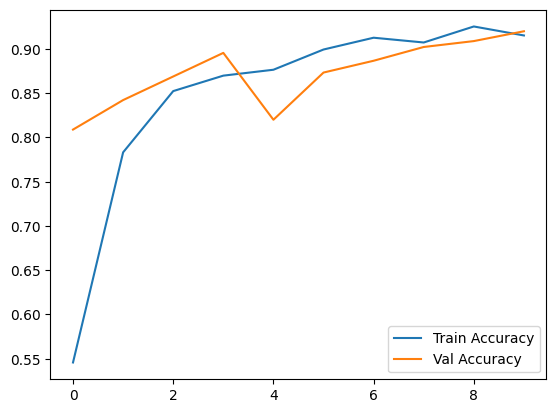

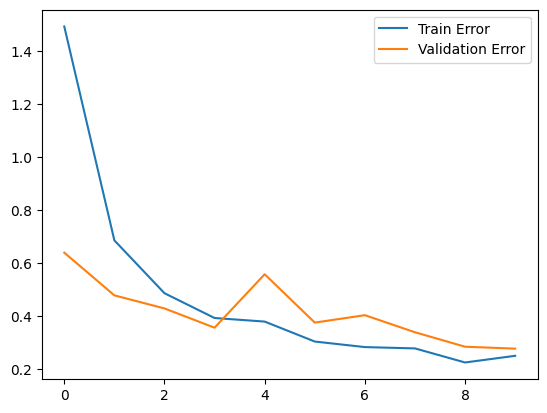

In [19]:
plt.plot(history.history["accuracy"],label="Train Accuracy")
plt.plot(history.history["val_accuracy"],label="Val Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Train Error")
plt.plot(history.history["val_loss"],label="Validation Error")
plt.legend()
plt.show()

In [20]:
# save disease plant model
model_disease.save("Model_Disease_Classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# Load model keras
model = tf.keras.models.load_model('Model_Disease_Classification.h5')

# Konversi model keras ke model TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke dalam file
with open('Model_Disease_Classification.tflite', 'wb') as f:
    f.write(tflite_model)

# Prediksi gambar penyakit

In [22]:
from tensorflow.keras.models import load_model
# model.load_('save_model/model4.h5')
model_disease.load_weights('Model_Disease_Classification.h5')

In [23]:
# Memilih indeks gambar yang ingin diprediksi
n = 20

# Memuat gambar dari dataset validasi
input_image_path = '/content/Dataset_Floravista/FLORA VISTA/PENYAKIT/BLACK_ROT/BLACK_ROT_009-4181-88e6-bdbf70fe33c3___JR_FrgE.S 8655.jpg'  # Ganti dengan path gambar yang ingin diprediksi
input_image = cv2.imread(input_image_path)  # Membaca gambar
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  # Mengubah format warna BGR ke RGB
input_image = cv2.resize(input_image, (224, 224))  # Mengubah ukuran gambar
input_image = input_image / 255.0  # Normalisasi nilai piksel

# Menambahkan dimensi batch pada gambar
input_image = input_image[np.newaxis, ...]

# Melakukan prediksi menggunakan model
predictions = model_disease.predict(input_image)

# Mendapatkan label sebenarnya
true_label = "Black rot"  # Ganti dengan label sebenarnya yang sesuai dengan gambar yang diprediksi

# Mencetak label sebenarnya dan hasil prediksi
print("Label sebenarnya:", true_label)
print("Prediksi model:", predictions)

1/1 [==============================] - 1s 1s/step
Label sebenarnya: Black rot
Prediksi model: [[8.1940377e-03 2.0389433e-04 9.9127114e-01 3.4845735e-07 2.8398347e-06
  1.3313845e-06 1.1379369e-06 2.4814693e-07 7.8200908e-05 9.4382648e-07
  1.3271302e-04 5.9704030e-06 1.4590212e-07 5.6028020e-05 5.1014340e-05]]


1/1 [==============================] - 0s 85ms/step
Predicted class: BLACK_ROT
Confidence: 0.72160137


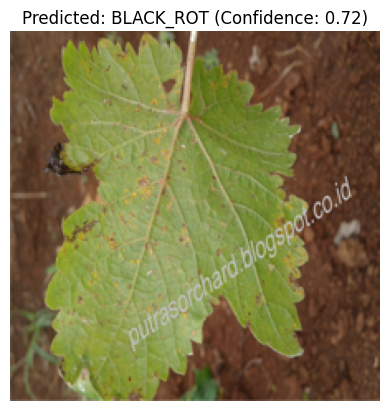

In [24]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi untuk mengunduh dan praproses gambar
def preprocess_image_from_url(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)  # Ubah ukuran gambar
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalisasi sesuai dengan MobileNetV2
    return img, img_array

# URL gambar yang ingin diuji
image_url = " https://1.bp.blogspot.com/-tdptTvf7SJE/V9furLotnPI/AAAAAAAAAJI/bezccCUFDY4Rz3SXrHfIwjPpDDadv-3twCEw/s1600/Graphic2.JPG "

# Prakiraan dan praproses gambar
original_img, processed_img = preprocess_image_from_url(image_url, target_size=(224, 224))

# Lakukan prediksi
prediction = model_disease.predict(processed_img)

# Interpretasi hasil prediksi
predicted_class_index = np.argmax(prediction)
confidence = prediction[0][predicted_class_index]

# Membuat kamus label
label_dict = train_generator_disease.class_indices
index_to_label = {v: k for k, v in label_dict.items()}

# Print hasil
predicted_label = index_to_label[predicted_class_index]
print("Predicted class:", predicted_label)
print("Confidence:", confidence)

# Tampilkan gambar beserta prediksi
plt.imshow(original_img)
plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 76ms/step
Predicted class: LEAF_SCORCH
Confidence: 0.9973755


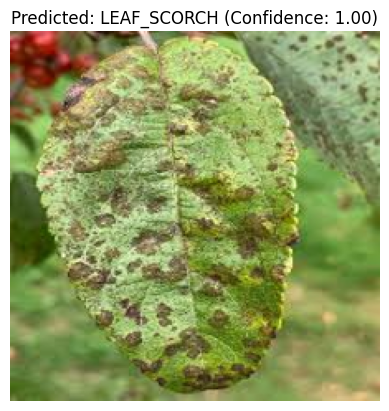

In [25]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi untuk mengunduh dan praproses gambar
def preprocess_image_from_url(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)  # Ubah ukuran gambar
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalisasi sesuai dengan MobileNetV2
    return img, img_array

# URL gambar yang ingin diuji
image_url = " https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRrhDjUL8CvUcVtmv8_UTpE7hiWA2-x_zKOzw&s"

# Prakiraan dan praproses gambar
original_img, processed_img = preprocess_image_from_url(image_url, target_size=(224, 224))

# Lakukan prediksi
prediction = model_disease.predict(processed_img)

# Interpretasi hasil prediksi
predicted_class_index = np.argmax(prediction)
confidence = prediction[0][predicted_class_index]

# Membuat kamus label
label_dict = train_generator_disease.class_indices
index_to_label = {v: k for k, v in label_dict.items()}

# Print hasil
predicted_label = index_to_label[predicted_class_index]
print("Predicted class:", predicted_label)
print("Confidence:", confidence)

# Tampilkan gambar beserta prediksi
plt.imshow(original_img)
plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 64ms/step
Predicted class: POWDERY
Confidence: 0.9999659


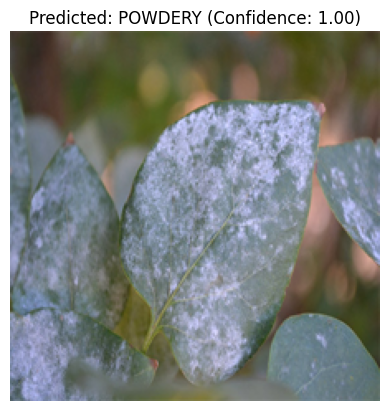

In [26]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi untuk mengunduh dan praproses gambar
def preprocess_image_from_url(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)  # Ubah ukuran gambar
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalisasi sesuai dengan MobileNetV2
    return img, img_array

# URL gambar yang ingin diuji
image_url = "https://hyg.ipm.illinois.edu/photos/powdery_mildew_on_common_lilac.jpg"
# Prakiraan dan praproses gambar
original_img, processed_img = preprocess_image_from_url(image_url, target_size=(224, 224))

# Lakukan prediksi
prediction = model_disease.predict(processed_img)

# Interpretasi hasil prediksi
predicted_class_index = np.argmax(prediction)
confidence = prediction[0][predicted_class_index]

# Membuat kamus label
label_dict = train_generator_disease.class_indices
index_to_label = {v: k for k, v in label_dict.items()}

# Print hasil
predicted_label = index_to_label[predicted_class_index]
print("Predicted class:", predicted_label)
print("Confidence:", confidence)

# Tampilkan gambar beserta prediksi
plt.imshow(original_img)
plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()


In [ ]:
# Simpan arsitektur model ke file JSON
model_json = model_disease.to_json()
with open("model_disease.json", "w") as json_file:
    json_file.write(model_json)

# Simpan bobot model ke file HDF5
model_disease.save_weights("model_disease_weights.h5")

print("Model disimpan ke file model_disease.json dan model_disease_weights.h5")


Model disimpan ke file model_disease.json dan model_disease_weights.h5


In [ ]:
# Simpan keseluruhan model ke file HDF5
model_disease.save("model_disease_full.h5")

print("Keseluruhan model disimpan ke file model_disease_full.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Keseluruhan model disimpan ke file model_disease_full.h5


In [ ]:
import tensorflow as tf

# Asumsi model_disease adalah model yang sudah dilatih
# Simpan keseluruhan model ke file HDF5
model_disease.save("model_disease_full.h5")

print("Keseluruhan model disimpan ke file model_disease_full.h5")

# Konversi model Keras ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_disease)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open("model_disease.tflite", "wb") as tflite_file:
    tflite_file.write(tflite_model)

print("Model disimpan dalam format TFLite ke file model_disease.tflite")


Keseluruhan model disimpan ke file model_disease_full.h5


Model disimpan dalam format TFLite ke file model_disease.tflite
